In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [24]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [28]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(784, 128, bias=False)
        self.linear_2 = nn.Linear(128, 10, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        x = self.softmax(x)
        return x

model = Net()
loss_fn = nn.NLLLoss(reduction="none")
optim = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0) 
batch_size = 128

In [29]:
losses = []
accuracies = []

for i in (t := trange(1000)):
    sample = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = torch.tensor(X_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[sample]).long()
    model.zero_grad()

    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_fn(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()

    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

loss 0.29 accuracy 0.94: 100%|██████████| 1000/1000 [00:01<00:00, 632.28it/s]


(0.0, 2.0)

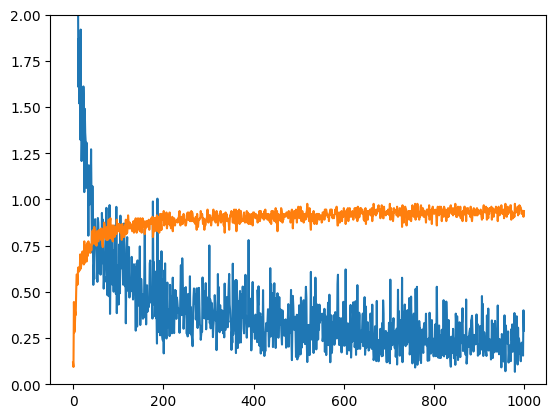

In [34]:
plt.plot(losses)
plt.plot(accuracies)
plt.ylim(0, 2)